In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `/mnt/064AC6424AC62E6D/git_workspace/16715/hopper-sim/scripts/Project.toml`


In [2]:
using RigidBodyDynamics
using LinearAlgebra
using MeshCatMechanisms
using MeshCat
using StaticArrays

WebIO._IJuliaInit()

In [3]:
l0 = 0.15
l1 = 0.3

l2 = 0.3
l3 = 0.15
l4 = 0.15
l34 = l3+l4

m0 = 1.0
m1 = 1.0
m2 = 1.0
m3 = 1.0

g = 9.81

# I1 = m1*(l1^2)
# I2 = m2*(l2^2)

9.81

In [4]:
world = RigidBody{Float64}("world")
doublependulum = Mechanism(world; gravity = SVector(0, 0, g))

Spanning tree:
Vertex: world (root)
No non-tree joints.

In [5]:
curdir = pwd()
urdfpath = joinpath(curdir, "../../res/flyhopper_parallel/urdf/flyhopper_parallel.urdf")
doublependulum = parse_urdf(urdfpath, floating=false)
state = MechanismState(doublependulum)

I/O warning : failed to load external entity "/mnt/064AC6424AC62E6D/git_workspace/16715/hopper-sim/scripts/../../res/flyhopper_parallel/urdf/flyhopper_parallel.urdf"


LoadError: LightXML.XMLParseError{String}("Failure in parsing an XML file.")

In [6]:
function f_1(x)
    # parallel mechanism dynamics
    q0 = x[1]
    q0d = x[2]
    q1 = x[3]
    q1d = x[4]
    q2 = x[5]
    q2d = x[6]
    q3 = x[7]
    q3d = x[8]
    
    # Mass matrix
    M = [ 1.0*l0^2*m0 + l0^2*m1 + 2*l0*l1*m1*cos(q1) + l1^2*m1  l0*l1*m1*cos(q1) + l1^2*m1  0  0;
          l0*l1*m1*cos(q1) + l1^2*m1  l1^2*m1  0  0;
          0  0  1.0*l2^2*m2 + l2^2*m3 + 2*l2*l34*m3*cos(q3) + l34^2*m3  l2*l34*m3*cos(q3) + l34^2*m3;
          0  0  l2*l34*m3*cos(q3) + l34^2*m3  l34^2*m3]
    
    # Coriolis term
    C = [ -2*l0*l1*m1*q0d*q1d*sin(q1) - l0*l1*m1*q1d^2*sin(q1);
          l0*l1*m1*q0d^2*sin(q1);
          -2*l2*l34*m3*q2d*q3d*sin(q3) - l2*l34*m3*q3d^2*sin(q3);
          l2*l34*m3*q2d^2*sin(q3)]
    
    # Gravity term
    G = [g*l0*m0*cos(q0) + g*l0*m1*cos(q0) + g*l1*m1*cos(q0 + q1);
         g*l1*m1*cos(q0 + q1);
         g*l2*m2*cos(q2) + g*l2*m3*cos(q2) + g*l34*m3*cos(q2 + q3);
         g*l34*m3*cos(q2 + q3)]
    
    # Constraint fn
    c = [l0*cos(q0) + l1*cos(q0 + q1) - l2*cos(q2) - l3*cos(q2 + q3);
         l0*sin(q0) + l1*sin(q0 + q1) - l2*sin(q2) - l3*sin(q2 + q3)]
    
    # Constraint Jacobian
    D = [-l0*sin(q0) - l1*sin(q0 + q1)  -l1*sin(q0 + q1)  l2*sin(q2) + l3*sin(q2 + q3)  l3*sin(q2 + q3);
         l0*cos(q0) + l1*cos(q0 + q1)    l1*cos(q0 + q1)   -l2*cos(q2) - l3*cos(q2 + q3) -l3*cos(q2 + q3)]
    
    # del/delq(D*qdot)*qdot
    d = [q0d*(-l1*q1d*cos(q0 + q1) + q0d*(-l0*cos(q0) - l1*cos(q0 + q1))) + q1d*(-l1*q0d*cos(q0 + q1) -
            l1*q1d*cos(q0 + q1)) + q2d*(l3*q3d*cos(q2 + q3) + q2d*(l2*cos(q2) + l3*cos(q2 + q3))) +
            q3d*(l3*q2d*cos(q2 + q3) + l3*q3d*cos(q2 + q3));
         q0d*(-l1*q1d*sin(q0 + q1) + q0d*(-l0*sin(q0) - l1*sin(q0 + q1))) + q1d*(-l1*q0d*sin(q0 + q1) -
            l1*q1d*sin(q0 + q1)) + q2d*(l3*q3d*sin(q2 + q3) + q2d*(l2*sin(q2) + l3*sin(q2 + q3))) +
            q3d*(l3*q2d*sin(q2 + q3) + l3*q3d*sin(q2 + q3))]
    
    # first derivative of constraint fn
    cd = [-l1*q1d*sin(q0 + q1) + l3*q3d*sin(q2 + q3) + q0d*(-l0*sin(q0) - l1*sin(q0 + q1)) +
              q2d*(l2*sin(q2) + l3*sin(q2 + q3));
          l1*q1d*cos(q0 + q1) - l3*q3d*cos(q2 + q3) + q0d*(l0*cos(q0) + l1*cos(q0 + q1)) +
              q2d*(-l2*cos(q2) - l3*cos(q2 + q3))]
    
    α = 50000.0
    β = 500.0
    
    e = D*(M\(D'*(α*c + β*cd)))
    
    KKT = [M -D';
           D zeros(2,2)]
    RHS = [- G - C;
           -(d + e)]
    
    sol = KKT\RHS
    qdd = sol[1:4]
    
    λ = sol[5:6]
    # qdd = M\(- G - C)
    q0dd = qdd[1]
    q1dd = qdd[2]
    q2dd = qdd[3]
    q3dd = qdd[4]
    
    ẋ = zeros(8)
    ẋ[1] = q0d # q0 dot
    ẋ[2] = q0dd # q0 double dot
    ẋ[3] = q1d # q1 dot
    ẋ[4] = q1dd # q1 double dot
    ẋ[5] = q2d # q2 dot
    ẋ[6] = q2dd # q2 double dot
    ẋ[7] = q3d # q3 dot
    ẋ[8] = q3dd # q3 double dot

    return ẋ
end

f_1 (generic function with 1 method)

In [7]:
function checkval(val, max, name)
    if val > max
        @show val
        error(name)
    end
end
#=
#---#
if isnan(qdd[1])
    @show qdd
    error("A!")
end
#---#
=#

checkval (generic function with 1 method)

In [8]:
function rk4_step(f,xk,h)

    f1 = f(xk)
    f2 = f(xk + 0.5*h*f1)
    f3 = f(xk + 0.5*h*f2)
    f4 = f(xk + h*f3)
    
    xn = xk + (h/6.0).*(f1 + 2*f2 + 2*f3 + f4)

    return xn
end

rk4_step (generic function with 1 method)

In [9]:
Tf = 10.0
h = 0.001 #20 Hz
N = Int(floor(Tf./h + 1))
thist = h.*Array(0:(N-1));

In [10]:
function simulate!(xtraj, N)
    for k = 1:(N-1)
        xtraj[:,k+1] .= rk4_step(f_1, copy(xtraj[:,k]), h)
    end
end

simulate! (generic function with 1 method)

In [11]:
x0 = [-30*pi/180; 0.0; -120*(pi/180); 0.0; -150*(pi/180); 0.0; 120*(pi/180); 0.0]
xtraj = zeros(8,N)
xtraj[:,1] = x0;

In [12]:
simulate!(xtraj, N)

In [13]:
q0 = -xtraj[1, :] .- 30*(pi/180)
q1 = -xtraj[3, :] .- 120*(pi/180)
q2 = -xtraj[5, :] .- 150*(pi/180)
q3 = -xtraj[7, :] .+ 120*(pi/180)

qs = convert(AbstractArray{Float64}, [q2 q0 q3 q1]) 
ts = convert(AbstractVector{Float64}, thist) # AbstractVector(thist)
q_array = [ qs[i,:] for i in 1:size(qs,1)] 

10001-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0]
 [-1.0788228971048142e-5, 1.34852862139212e-5, 2.427351518496934e-5, -2.427351518496934e-5]
 [-4.3153237479831574e-5, 5.394154684990049e-5, 9.709478432951002e-5, -9.709478432951002e-5]
 [-9.709599042473371e-5, 0.00012136998803313759, 0.0002184659784578713, -0.0002184659784578713]
 [-0.0001726180963474988, 0.00021577262044647494, 0.00038839071679408477, -0.00038839071679408477]
 [-0.00026972180799633705, 0.0003371522600421617, 0.0006068740680387208, -0.0006068740680387208]
 [-0.0003884100231186238, 0.00048551252903838993, 0.0008739225521572358, -0.0008739225521572358]
 [-0.0005286862854769758, 0.0006608578572019352, 0.001189544142679022, -0.001189544142679022]
 [-0.0006905547860953654, 0.0008631934834165689, 0.0015537482695120453, -0.0015537482695120453]
 [-0.0008740203647303879, 0.0010925254575390175, 0.0019665458222695165, -0.0019665458222695165]
 [-0.0010790885115712356, 0.001348860642542915, 0.0024279491541143727, -0.00242

In [14]:
# mvis = MechanismVisualizer(doublependulum, Skeleton(randomize_colors=true, inertias=false));
mvis = MechanismVisualizer(doublependulum, URDFVisuals(urdfpath));

render(mvis)

I/O warning : failed to load external entity "/mnt/064AC6424AC62E6D/git_workspace/16715/hopper-sim/scripts/../../res/flyhopper_parallel/urdf/flyhopper_parallel.urdf"


LoadError: LightXML.XMLParseError{String}("Failure in parsing an XML file.")

In [15]:
# [q2 q0 q3 q1]
set_configuration!(mvis, [-x0[5]-150*(pi/180), -x0[1]-30*(pi/180), -x0[7]+120*(pi/180), -x0[3]-120*(pi/180)])

LoadError: UndefVarError: mvis not defined

In [16]:
# Now we can simply call `simulate`, which will return a tuple consisting of:
# * simulation times (a `Vector` of numbers)
# * joint configuration vectors (a `Vector` of `Vector`s)
# * joint velocity vectors (a `Vector` of `Vector`s)

animation = Animation(mvis, ts, -q_array)
setanimation!(mvis, animation)
# MeshCatMechanisms.animate(mvis, ts, qs; realtimerate = 1.);

LoadError: UndefVarError: mvis not defined

In [17]:
#Energy Functions

function T(x)
    q0 = x[1]
    q0d = x[2]
    q1 = x[3]
    q1d = x[4]
    q2 = x[5]
    q2d = x[6]
    q3 = x[7]
    q3d = x[8]
    
    T = 0.5*l0^2*m0*q0d^2 + 0.5*l2^2*m2*q2d^2 + 0.5*m1*(l0^2*q0d^2 + 
        2*l0*l1*q0d^2*cos(q1) + 2*l0*l1*q0d*q1d*cos(q1) + l1^2*q0d^2 + 
        2*l1^2*q0d*q1d + l1^2*q1d^2) + 0.5*m3*(l2^2*q2d^2 + 
        2*l2*l34*q2d^2*cos(q3) + 2*l2*l34*q2d*q3d*cos(q3) + 
        l34^2*q2d^2 + 2*l34^2*q2d*q3d + l34^2*q3d^2)
end

function U(x)
    q0 = x[1]
    q1 = x[3]
    q2 = x[5]
    q3 = x[7]
    
    y0 = l0*sin(q0)
    y1 = l0*sin(q0) + l1*sin(q0 + q1)

    y2 = l2*sin(q2)
    y3 = l2*sin(q2) + l34*sin(q2 + q3)
    
    U0 = m0*g*y0 + m1*g*y1
    U2 = m2*g*y2 + m3*g*y3
    
    return U0 + U2
end

function H(x)
    U(x) + T(x)
end

H (generic function with 1 method)

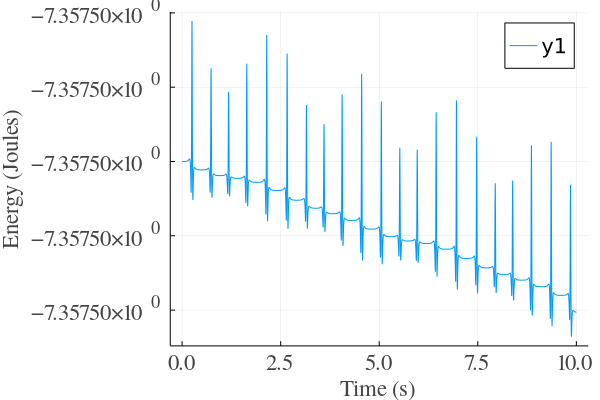

In [22]:
#Plot total energy
using Plots
fnt = Plots.font("Times Roman")

E = zeros(N)
for k = 1:N
    E[k] = H(xtraj[:, k])
end

p1 = plot(thist,E, xlabel="Time (s)", ylabel="Energy (Joules)", 
    titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt, fmt = :png)